In [1]:
from __future__ import print_function

import os
import sys
import random
import tarfile
import scipy.io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import ndimage
from six.moves import cPickle as pickle
from IPython.display import display, Image
from sklearn.linear_model import SGDClassifier
from six.moves.urllib.request import urlretrieve
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [5]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """
    A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent
        
def maybe_download(filename, force=False):
    """
    Download a file if not present, and make sure it's the right size.
    """
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    else:
        print(filename, 'is already downloaded. Skipped.')
        
    return filename

In [6]:
maybe_download('train_32x32.mat')
maybe_download('test_32x32.mat')

train_32x32.mat is already downloaded. Skipped.
test_32x32.mat is already downloaded. Skipped.


'test_32x32.mat'

In [10]:
from sklearn.cross_validation import train_test_split

train_data = scipy.io.loadmat('train_32x32.mat', variable_names='X').get('X').transpose((3,0,1,2))
train_labels = scipy.io.loadmat('train_32x32.mat', variable_names='y').get('y')[:,0]

print("Not splitted shape", train_data.shape)

valid_data = scipy.io.loadmat('test_32x32.mat', variable_names='X').get('X').transpose((3,0,1,2))
valid_labels = scipy.io.loadmat('test_32x32.mat', variable_names='y').get('y')[:,0]

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.33, random_state=42)

print("Shape sum", train_data.shape[0] + test_data.shape[0])
print("Splitted shape", train_data.shape, test_data.shape)

Not splitted shape (73257, 32, 32, 3)
Shape sum 73257
Splitted shape (49082, 32, 32, 3) (24175, 32, 32, 3)


In [11]:
# Replace 10 with 0 for 0 digit
train_data[train_data == 10] = 0
test_data[test_data == 10] = 0
valid_data[valid_data == 10] = 0

In [12]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def make_gray(image):
    '''
    Converge 3 level image to 1 level(gray scale), since digit's color is useless.
    Used information from this paperwork http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf
    And SOF: http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
    '''
    image = image.astype(float)
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray[:,:,:,0]

In [13]:
train_data = make_gray(train_data)
test_data = make_gray(test_data)
valid_data = make_gray(valid_data)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(49082, 32, 32) (49082,)
(24175, 32, 32) (24175,)
(26032, 32, 32) (26032,)


In [14]:
def normalize_contrast(image, min_divisor=1e-4):
    """
    Contrast Normalization
    """
    size = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    normalized_image = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(size):
        normalized_image[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return normalized_image

In [15]:
train_data = normalize_contrast(train_data)
test_data = normalize_contrast(test_data)
valid_data = normalize_contrast(valid_data)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(49082, 32, 32) (49082,)
(24175, 32, 32) (24175,)
(26032, 32, 32) (26032,)


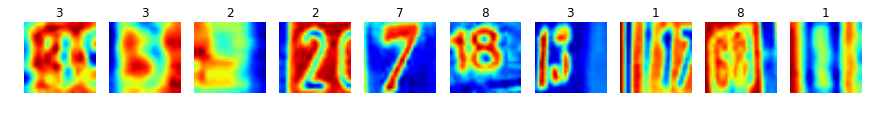

In [16]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[j,:,:])

In [17]:
pickle_file = 'SVHN.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_data': train_data,
        'train_labels': train_labels,
        'valid_dataset': valid_data,
        'valid_labels': valid_labels,
        'test_dataset': test_data,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 813475211
